# INF554 Kaggle Competition
#### Francisco, Alex and Aksel

## Imports and Loading

In [2]:
import random
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
import seaborn as sns
import os
import networkx as nx
import pdb
import pickle
from collections import Counter
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_extraction import text as fe
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
import datetime
import time
import keras
import lightgbm
import spacy
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
import nltk
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin

Using TensorFlow backend.


In [4]:
with open(r"training.txt", "r") as f:
    reader = csv.reader(f)
    training  = list(reader)
# in order of training examples
training = [element[0].split(" ") for element in training]
training = pd.DataFrame(training, columns=['Node1', 'Node2', 'Link'])
print("Training examples shape: {}".format(training.shape))

with open(r"testing.txt", "r") as f:
    reader = csv.reader(f)
    testing  = list(reader)
# in order of testing examples
testing = [element[0].split(" ") for element in testing]
testing = pd.DataFrame(testing, columns=['Node1', 'Node2'])
print("Testing examples shape: {}".format(testing.shape))

Training examples shape: (453797, 3)
Testing examples shape: (113450, 2)


In [5]:
if not os.path.exists(r'pickles'):
    os.mkdir(r'pickles')

In [6]:
'''
uncomment lines for reduced corpus with stopword removal. In future integrate stemmer here, multi-language
'''
NODE_INFO_DIRECTORY = r"node_information/text/"

corpus_path = r"pickles/corpus.PICKLE" 
ids_path = r"pickles/IDs.PICKLE"
if os.path.exists(corpus_path):
    with open(corpus_path, 'rb') as f:
        corpus = pickle.load(f)
    f.close()
    with open(ids_path, 'rb') as f:
        ids = pickle.load(f)
    f.close()
else:
    corpus = []
    ids = []
    for filename in tqdm(os.listdir(NODE_INFO_DIRECTORY)):
        with open(NODE_INFO_DIRECTORY + filename, 'r', encoding='UTF-8', errors='ignore') as f:
            doc_string = []
            for line in f:
                [doc_string.append(token) for token in line.lower().strip().split(" ")]
            corpus.append(' '.join(doc_string))
            ids.append(filename[:-4])
    with open(corpus_path, '+wb') as f:
        pickle.dump(corpus, f)
    f.close()
    with open(ids_path, '+wb') as f:
        pickle.dump(ids, f)
    f.close() 

# in order of alphabetical text information i.e. 0, 1, 10, 100
node_info = pd.DataFrame({'ID': ids, 'Corpus': corpus})
node_info_ID = node_info.set_index(['ID'])
print("Training node info shape: {}".format(node_info.shape))

100%|████████████████████████████████████████████████████████████████████████████| 33226/33226 [05:56<00:00, 93.27it/s]


Training node info shape: (33226, 2)


In [9]:
'''
keep_indices = random.sample(range(len(training)), k=int(len(training) * 0.05))
data_train_val = training.iloc[keep_indices]
data_train = training.loc[~training.index.isin(keep_indices)]
'''
data_train_val = training

In [10]:
linked_nodes = data_train_val.loc[data_train_val['Link']=='1']
linked_nodes = linked_nodes[['Node1', 'Node2']]
linked_nodes.to_csv('linked_nodes.txt', sep=' ', index=False, header=False)
G=nx.read_edgelist('linked_nodes.txt', create_using=nx.Graph(), nodetype = str)

## Training

In [11]:
# classification methodology comparisons
def multi_classifier(X_train, X_test, y_train, y_test):
    classifier_names = ['LR', 'SVM', 'RF', 'GBM', 'LGBM', 'MLP', 'BAG', 'KNN']
    metrics = ['F1', 'Accuracy']
    df_summary = pd.DataFrame(np.zeros((len(metrics), len(classifier_names))), 
                              columns = classifier_names, 
                              index = metrics)

    logreg = LogisticRegression()
    svm = SVC()
    rf = RandomForestClassifier()
    gbm = GradientBoostingClassifier()
    lgbm = lightgbm.LGBMClassifier()
    mlp = MLPClassifier()
    bag = BaggingClassifier()
    knn = KNeighborsClassifier()
   
    classifiers= [logreg, svm, rf, gbm, lgbm, mlp, bag, knn]
    for idx, classifier in enumerate(classifiers): 
        model = classifier.fit(X_train, y_train)
        predictions = model.predict(X_test)    
        f1 = f1_score(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        df_summary.iloc[0,idx]=np.round(f1, 4)
        df_summary.iloc[1,idx]=np.round(accuracy, 4)
    
    return df_summary

In [43]:
# classification methodology comparisons
def simpler_multi_classifier(X_train, X_test, y_train, y_test):
    classifier_names = ['LR', 'RF','LGBM']
    metrics = ['F1', 'Accuracy']
    df_summary = pd.DataFrame(np.zeros((len(metrics), len(classifier_names))), 
                              columns = classifier_names, 
                              index = metrics)

    logreg = LogisticRegression()
    rf = RandomForestClassifier()
    lgbm = lightgbm.LGBMClassifier()
   
    classifiers= [logreg, rf, lgbm]
    for idx, classifier in enumerate(classifiers): 
        model = classifier.fit(X_train, y_train)
        predictions = model.predict(X_test)    
        f1 = f1_score(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        df_summary.iloc[0,idx]=np.round(f1, 4)
        df_summary.iloc[1,idx]=np.round(accuracy, 4)
    
    return df_summary

In [29]:
# dictionary key indexes original training data
perf_val_data = pd.DataFrame(data_train_val.Node1.values, columns = ['Node1'])
perf_val_data['Node2'] = list(data_train_val.Node2.values)
perf_val_data['Link'] =  list(data_train_val.Link.values)
perf_val_data['original_index'] = list(data_train_val.index)

# dictionary key indexes original testing data
perf_test_data = pd.DataFrame(testing.Node1.values, columns = ['Node1'])
perf_test_data['Node2'] = list(testing.Node2.values)
perf_test_data['original_index'] = list(testing.index)

perf_test_data.head(2)

,Node1,Node2,original_index
0,870,10284,0
1,620,15300,1


## Load Features

In [11]:
feature_vector_path = r"pickles/perf_val_data.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        perf_val_data = pickle.load(f)
    f.close()

feature_vector_path = r"pickles/perf_test_data.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        perf_test_data = pickle.load(f)
    f.close()

In [85]:
# saving the features
feature_vector_path = r"pickles/perf_val_data.PICKLE"
if not os.path.exists(feature_vector_path):
    with open(feature_vector_path, '+wb') as f:
        pickle.dump(perf_val_data, f)
    f.close()
feature_vector_path = r"pickles/perf_test_data.PICKLE"
if not os.path.exists(feature_vector_path):
    with open(feature_vector_path, '+wb') as f:
        pickle.dump(perf_test_data, f)
    f.close()

## Text Based Features

In [23]:
corpus_matrix_path = r"pickles/corpus_word_matrix.PICKLE"
if os.path.exists(corpus_matrix_path):
    with open(corpus_matrix_path, 'rb') as f:
        corpus_word_matrix = pickle.load(f)
    f.close()
else:
    vectorizer1 = fe.CountVectorizer()
    corpus_word_matrix = vectorizer1.fit_transform(tqdm(corpus))
    with open(corpus_matrix_path, '+wb') as f:
        pickle.dump(corpus_word_matrix, f)
    f.close()

100%|███████████████████████████████████████████████████████████████████████████| 33226/33226 [02:34<00:00, 215.35it/s]


In [24]:
corpus_matrix_path = r"pickles/corpus_tfidf_matrix.PICKLE"
if os.path.exists(corpus_matrix_path):
    with open(corpus_matrix_path, 'rb') as f:
        corpus_tfidf_matrix = pickle.load(f)
    f.close()
else:
    vectorizer3 = fe.TfidfVectorizer()
    corpus_tfidf_matrix = vectorizer3.fit_transform(tqdm(corpus))
    with open(corpus_matrix_path, '+wb') as f:
        pickle.dump(corpus_tfidf_matrix, f)
    f.close()

100%|███████████████████████████████████████████████████████████████████████████| 33226/33226 [02:28<00:00, 223.47it/s]


In [30]:
def tfidf_similarity(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    index1 = ids.index(node1)
    index2 = ids.index(node2)
    sim = corpus_tfidf_matrix[index1] * corpus_tfidf_matrix[index2].T
    return sim.toarray()[0][0]

perf_val_data['tfidf_similarity']=list(map(lambda i:tfidf_similarity(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['tfidf_similarity']=list(map(lambda i:tfidf_similarity(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|██████████████████████████████████████████████████████████████████████████| 113450/113450 [24:26<00:00, 77.39it/s]


In [31]:
n_samples = 2000
n_features = 1000
n_components = 10

In [13]:
nmf_frobenius_path = r"pickles/nmf_frobenius_matrix.PICKLE"
if os.path.exists(nmf_frobenius_path):
    with open(nmf_frobenius_path, 'rb') as f:
        nmf_frobenius = pickle.load(f)
    f.close()
else:
    print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
          "n_samples=%d and n_features=%d..." % (corpus_tfidf_matrix.shape[0], n_features))

    nmf_frobenius = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(corpus_tfidf_matrix)
    with open(nmf_frobenius_path, '+wb') as f:
        pickle.dump(nmf_frobenius, f)
    f.close()

In [14]:
nmf_kd_path = r"pickles/nmf_kd_matrix.PICKLE"
if os.path.exists(nmf_kd_path):
    with open(nmf_kd_path, 'rb') as f:
        nmf_kd = pickle.load(f)
    f.close()
else:
    x = ''
    while (x not in ['n', 'y']):
        x = input("nmf_kd_matrix not available, recompute? y/n: ")
    if x == "y":
        print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
              "tf-idf features, n_samples=%d and n_features=%d..."
              % (n_samples, n_features))

        nmf_kd = NMF(n_components=n_components, random_state=1,
                  beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
                  l1_ratio=.5).fit(corpus_tfidf_matrix)

        with open(nmf_kd_path, '+wb') as f:
            pickle.dump(nmf_kd, f)
        f.close()

nmf_kd_matrix not available, recompute? y/n: n


In [15]:
lda_path = r"pickles/lda_matrix.PICKLE"
if os.path.exists(lda_path):
    with open(lda_path, 'rb') as f:
        lda = pickle.load(f)
    f.close()
else:
    print("Fitting LDA models with tf features, "
          "n_samples=%d and n_features=%d..."
          % (n_samples, n_features))
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)
    lda.fit(corpus_word_matrix)
    
    with open(lda_path, '+wb') as f:
        pickle.dump(lda, f)
    f.close()

In [10]:
def calculate_languages_ratios(text):
    languages_ratios = []
    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]
    for language in stopwords.fileids():
        stopwords_set = set(stopwords.words(language))
        words_set = set(words)
        common_elements = words_set.intersection(stopwords_set)
        languages_ratios.append(len(common_elements))
    if sum(languages_ratios) == 0:
        return np.zeros(len(languages_ratios))
    return np.array(languages_ratios)/sum(languages_ratios)

In [12]:
languages_nltk = {}
loop_size = len(node_info['Corpus'])
for i in tqdm(range(loop_size), total=loop_size, leave=True, position=0):
    try:
        languages_nltk[node_info['ID'][i]] =  calculate_languages_ratios(node_info['Corpus'][i])
    except:
        languages_nltk.append(None)

100%|████████████████████████████████████████████████████████████████████████████| 33226/33226 [11:01<00:00, 50.23it/s]


In [32]:
languages_nltk_path = r"pickles/languages_nltk.PICKLE"
if os.path.exists(languages_nltk_path):
    with open(languages_nltk_path, 'rb') as f:
        languages_nltk = pickle.load(f)
    f.close()
else:
    languages_nltk = {}
    loop_size = len(node_info['Corpus'])
    for i in tqdm(range(loop_size), total=loop_size, leave=True, position=0):
        try:
            languages_nltk[node_info['ID'][i]] =  calculate_languages_ratios(node_info['Corpus'][i])
        except:
            languages_nltk.append(None)
    
    with open(languages_nltk_path, '+wb') as f:
        pickle.dump(languages_nltk, f)
    f.close()

In [110]:
langs = {}
for i in languages_nltk:
    lang = str(np.argmax(languages_nltk[i]))
    if lang in langs:
        langs[lang] += 1
    else:
        langs[lang] = 1
list(zip([langs[i] for i in sorted(langs, key=lambda k:int(k))], stopwords.fileids()))

[(1413, 'arabic'),
 (114, 'azerbaijani'),
 (140, 'danish'),
 (238, 'dutch'),
 (7633, 'english'),
 (33, 'finnish'),
 (20755, 'french'),
 (708, 'german'),
 (21, 'greek'),
 (39, 'hungarian'),
 (38, 'indonesian'),
 (400, 'italian'),
 (2, 'kazakh'),
 (79, 'nepali'),
 (421, 'norwegian'),
 (257, 'portuguese'),
 (110, 'romanian'),
 (212, 'russian'),
 (550, 'slovene'),
 (47, 'spanish'),
 (16, 'swedish')]

In [33]:
def languages_nltk_similarity(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    sim = languages_nltk[node1] @ languages_nltk[node2].T
    return sim

perf_val_data['languages_similarity']=list(map(lambda i:languages_nltk_similarity(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['languages_similarity']=list(map(lambda i:languages_nltk_similarity(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|███████████████████████████████████████████████████████████████████████| 113450/113450 [00:04<00:00, 26556.66it/s]


In [34]:
def joint_length(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    length = len(node_info_ID['Corpus'].loc[node1]) * len(node_info_ID['Corpus'].loc[node2])
    return length

perf_val_data['joint_length']=list(map(lambda i:joint_length(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['joint_length']=list(map(lambda i:joint_length(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|████████████████████████████████████████████████████████████████████████| 113450/113450 [00:12<00:00, 9309.86it/s]


In [35]:
def file_distance(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    dist = abs(int(node1) - int(node2))
    return dist

perf_val_data['file_distance']=list(map(lambda i:file_distance(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['file_distance']=list(map(lambda i:file_distance(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|███████████████████████████████████████████████████████████████████████| 113450/113450 [00:04<00:00, 24172.84it/s]


## Graph Based Features

In [45]:
neighborsDict={}
for n in G.nodes():
    neighborsDict[n]= list(G.neighbors(n))  

pr = nx.pagerank(G, alpha=0.7)

#katz_nd = nx.katz_centrality_numpy(G, alpha=0.1, beta=1.0)

In [47]:
def common_neighbors(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        return len(set(neighborsDict[node1]).intersection(neighborsDict[node2]))
    else : 
        return 0

perf_val_data['common_neighbors']=list(map(lambda i:common_neighbors(i, training), 
                                           tqdm(perf_val_data['original_index'], leave=True, position = 0)))
perf_test_data['common_neighbors']=list(map(lambda i:common_neighbors(i, testing), 
                                            tqdm(perf_test_data['original_index'], leave=True, position = 0)))

100%|████████████████████████████████████████████████████████████████████████| 113450/113450 [00:19<00:00, 5784.13it/s]


In [48]:
def jaccard_coef(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        return [p for u,v,p in nx.jaccard_coefficient(G, [(node1, node2)])][0]
    else:
        return 0

perf_val_data['jaccard_coefficient']=list(map(lambda i:jaccard_coef(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['jaccard_coefficient']=list(map(lambda i:jaccard_coef(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [03:38<00:00, 519.01it/s]


In [49]:
def shortest_path(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        try:
            sp=nx.shortest_path(G, node1, node2)
            return len(sp)
        except nx.NetworkXNoPath:
            return 0
    else:
        return 0

perf_val_data['shortest_path']=list(map(lambda i:shortest_path(i, training), 
                                        tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['shortest_path']=list(map(lambda i:shortest_path(i, testing), 
                                         tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|████████████████████████████████████████████████████████████████████████| 113450/113450 [01:20<00:00, 1404.90it/s]


In [50]:
def page_rank(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        page_rank = (pr[node1] + pr[node2])/2
        return page_rank
    else: 
        return 0

perf_val_data['page_rank']=list(map(lambda i:page_rank(i, training), 
                                    tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['page_rank']=list(map(lambda i:page_rank(i, testing), 
                                     tqdm(perf_test_data['original_index'], position=0, leave=True)))


 33%|███████████████████████▍                                               | 149905/453797 [00:07<00:13, 23007.32it/s]


 68%|████████████████████████████████████████████████▎                      | 308573/453797 [00:14<00:06, 23693.42it/s]


100%|███████████████████████████████████████████████████████████████████████| 453797/453797 [00:20<00:00, 21925.74it/s]

 14%|█████████▉                                                              | 15625/113450 [00:00<00:05, 19479.72it/s]


100%|███████████████████████████████████████████████████████████████████████| 113450/113450 [00:05<00:00, 22474.25it/s]


In [51]:
def adamic_adar_index(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        return [p for u,v,p in nx.adamic_adar_index(G, [(node1, node2)])][0]
    else:
        return 0

perf_val_data['adamic_adar_index']=list(map(lambda i:adamic_adar_index(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['adamic_adar_index']=list(map(lambda i:adamic_adar_index(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [03:12<00:00, 590.67it/s]


In [52]:
def resource_allocation_index(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        return [p for u,v,p in nx.resource_allocation_index(G, [(node1, node2)])][0]
    else:
        return 0

perf_val_data['resource_allocation_index']=list(map(lambda i:resource_allocation_index(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['resource_allocation_index']=list(map(lambda i:resource_allocation_index(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [02:42<00:00, 697.08it/s]


In [53]:
def preferential_attachment(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        return [p for u,v,p in nx.preferential_attachment(G, [(node1, node2)])][0]
    else:
        return 0

perf_val_data['preferential_attachment']=list(map(lambda i:preferential_attachment(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['preferential_attachment']=list(map(lambda i:preferential_attachment(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|███████████████████████████████████████████████████████████████████████| 113450/113450 [00:06<00:00, 18146.29it/s]


In [54]:
d_columns = ['original_index', 'Link', 'Node1', 'Node2']
cols = [i for i in perf_val_data.columns if i not in d_columns]
X = perf_val_data[cols]
y = perf_val_data['Link']
y = list(map(lambda i: int(i), y))

In [56]:
perf_val_data

,Node1,Node2,Link,original_index,tfidf_similarity,languages_similarity,joint_length,file_distance,common_neighbors,jaccard_coefficient,shortest_path,page_rank,adamic_adar_index,resource_allocation_index,preferential_attachment
0,10481,5428,1,0,0.000308,0.055556,1076900,5053,1,0.005618,2,0.000106,0.192569,0.005556,7018
1,7353,30328,0,1,0.123736,0.104021,45677783,22975,0,0.000000,4,0.000016,0.000000,0.000000,36
2,8627,3547,1,2,0.106884,0.111662,1095230514,5080,4,0.005979,2,0.000362,0.605220,0.006253,24130
3,10232,21925,1,3,0.018472,0.096078,40659474,11693,0,0.000000,2,0.000673,0.000000,0.000000,1368
4,7110,3288,1,4,0.000000,0.000000,1367817,3822,0,0.000000,2,0.000045,0.000000,0.000000,624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453792,11186,4520,0,453792,0.000499,0.018232,1536599835,6666,2,0.007905,3,0.000157,0.428844,0.041824,2684
453793,12892,31446,0,453793,0.141404,0.167155,89546532,18554,0,0.000000,4,0.000022,0.000000,0.000000,80
453794,16857,23822,0,453794,0.107300,0.152658,355052800,6965,1,0.058824,3,0.000018,0.156530,0.001681,81
453795,5520,6394,1,453795,0.282119,0.160058,2140911864,874,1,0.004854,2,0.000122,0.203556,0.007353,4706


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
simpler_multi_classifier(X_train, X_test, y_train, y_test)

C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,LR,RF,LGBM
F1,0.7692,0.9999,0.9994
Accuracy,0.6249,0.9999,0.9993


## Feature Importance

In [60]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, np.round(predictions)))

0.9994475462826918


In [58]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = model_lgbm.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)

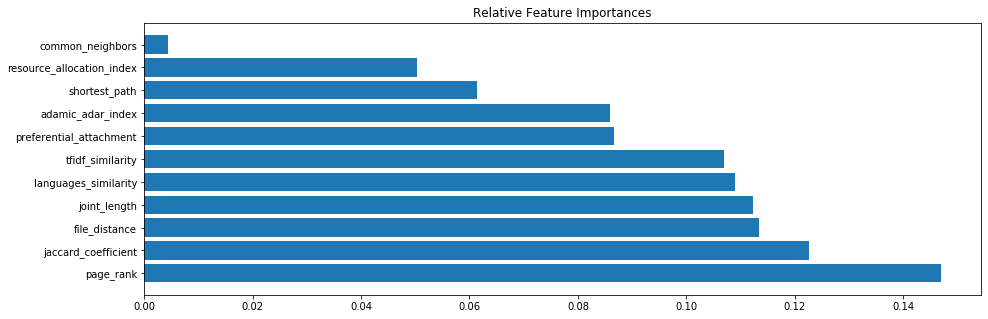

In [59]:
importance = np.array(features.values.reshape(-1))
importance = list(importance/importance.sum(axis=0,keepdims=1))

bars = list(features.index.values)

y_pos = np.arange(len(bars))

fig, ax = plt.subplots(figsize=(15,5))

# Create horizontal bars
plt.barh(y_pos, importance)

# Create names on the y-axis
plt.yticks(y_pos, bars)
# Add title
plt.title("Relative Feature Importances")

# Show graphic
plt.show()

## Model Comparison

In [111]:
boucle = 10
errors = np.empty((10,7))

error_list = []
for i in range(boucle):
    print(i+1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    error_list.append(multi_classifier(X_train, X_test, y_train, y_test))
    
error_df = pd.concat(error_list)

1


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

2


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

3


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

4


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

5


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

6


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

7


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

8


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

9


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

10


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

Text(0.5, 1.0, 'F1 Score')

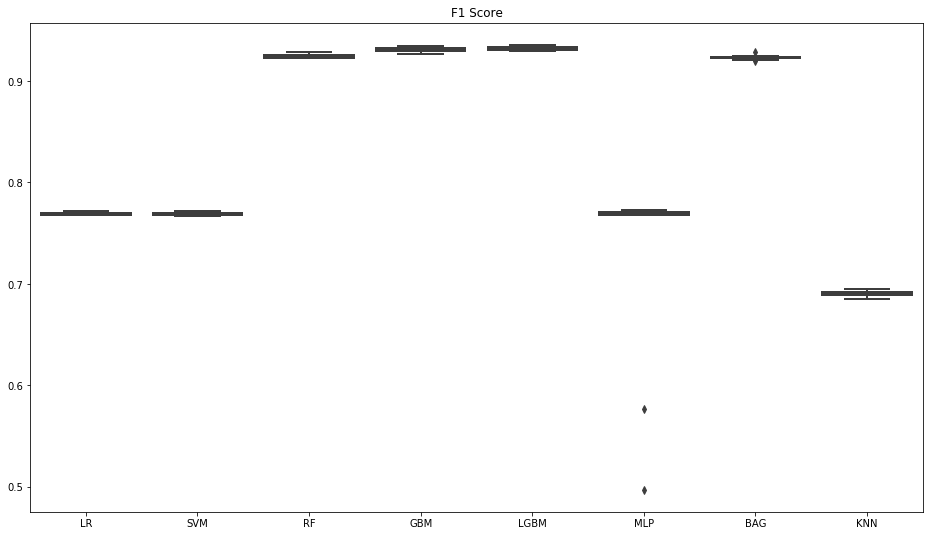

In [112]:
fig, ax = plt.subplots(figsize=(16,9))
x_plot = list(error_df.columns.values) * 10
y_plot = list(error_df.loc['F1'].values.reshape(-1))
sns.boxplot(x_plot, y_plot, linewidth=2)
plt.title("F1 Score")

## Prediction

In [61]:
d_columns = ['original_index', 'Node1', 'Node2']
cols = [i for i in perf_test_data.columns if i not in d_columns]

model = lightgbm.LGBMClassifier()
model = model.fit(X, y)
test = perf_test_data[cols]
predictions = model.predict(test)

In [62]:
final_pred = pd.concat([perf_test_data['original_index'], pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("full_train_prediction.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

## Hyperparameter Tuning

In [29]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    pred_label = np.round(preds)
    f_score = f1_score(pred_label, labels)
    return 'f1_score', f_score, True

def hyperopt(X, y, params):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)
    train_data = lightgbm.Dataset(X_train, label=y_train)
    valid_data = lightgbm.Dataset(X_val, label=y_val)

    space = {
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.5)),
        "max_depth": hp.choice("max_depth", [3, 4, 5, 6, 7]),
        "num_leaves": hp.choice("num_leaves", np.linspace(10, 200, 50, dtype=int)),
        "feature_fraction": hp.quniform("feature_fraction", 0.6, 1.0, 0.1),
        "reg_alpha": hp.uniform("reg_alpha", 0, 2),
        "reg_lambda": hp.uniform("reg_lambda", 0, 2),
        "min_child_weight": hp.uniform('min_child_weight', 0.5, 10),
    }

    def objective(hyperparams):
        model = lightgbm.train({**params, **hyperparams}, train_data, 300, 
                               valid_data, early_stopping_rounds=30, verbose_eval=0, feval = evalerror)

        score = model.best_score["valid_0"]['f1_score']
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, trials=trials,
                algo=tpe.suggest, max_evals=10, verbose=1,
                rstate=np.random.RandomState(1))

    hyperparams = space_eval(space, best)

    print(f"auc = {-trials.best_trial['result']['loss']:0.4f} {hyperparams}")

    return hyperparams


In [30]:
params = {
    "objective": "binary",
    "metric": 'f1_score',
    "verbosity": -1,
    "seed": 1,
    "num_threads": 4
}
hyperparams = hyperopt(X, y, params)

100%|██████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.20s/it, best loss: -0.9360667129951356]
auc = 0.9361 {'feature_fraction': 1.0, 'learning_rate': 0.06884784274135033, 'max_depth': 6, 'min_child_weight': 3.5562675698370647, 'num_leaves': 153, 'reg_alpha': 0.12330346362844646, 'reg_lambda': 1.4052899848887177}


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

train_data = lightgbm.Dataset(X_train, label=y_train)
valid_data = lightgbm.Dataset(X_test, label=y_test)

model = lightgbm.train({**params, **hyperparams}, train_data, 5000,
                       valid_data, early_stopping_rounds=100, verbose_eval=100, feval = evalerror)

predictions = model.predict(X_test)
print(f1_score(y_test, np.round(predictions)))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1_score: 0.934259
[200]	valid_0's f1_score: 0.93389
Early stopping, best iteration is:
[167]	valid_0's f1_score: 0.935312
0.9353118479016925


In [27]:
d_columns = ['original_index', 'Node1', 'Node2']
cols = [i for i in perf_test_data.columns if i not in d_columns]

model = lightgbm.LGBMClassifier(**hyperparams)
model = model.fit(X, y, eval_metric = evalerror)
test = perf_test_data[cols]
predictions = model.predict(test)

In [28]:
final_pred = pd.concat([perf_test_data['original_index'], pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("distance_prediction2.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)